# Load Data and check recording


In [2]:
import spikeinterface.full as si
import matplotlib.pyplot as plt
import numpy as np
import probeinterface as pi
from pathlib import Path
import pandas as pd 
import os, sys
import shutil
from pprint import pprint 
import time as time
%load_ext autoreload
%autoreload 2

import bombcell as bc

    
global_job_kwargs = dict(n_jobs=-3, chunk_duration="10s",progress_bar=True)
si.set_global_job_kwargs(**global_job_kwargs)


basefolder= r"D:\Data\raw\7644_recall"
base_path = Path(basefolder)
metapath = base_path / 'Meta'
if not os.path.isdir(metapath):
   os.makedirs(metapath)



recording =  si.read_spikeglx(basefolder, stream_id='imec0.ap', load_sync_channel=False)
lfp = si.read_spikeglx(basefolder, stream_id='imec0.lf', load_sync_channel=False)
event =  si.read_spikeglx(basefolder, stream_id='nidq', load_sync_channel=False)
print(recording)





✅ ipywidgets available - interactive GUI ready
SpikeGLXRecordingExtractor: 384 channels - 29999.900000 Hz - 1 segments - 139,385,537 samples 
                            4,646.20s (1.29 hours) - int16 dtype - 99.70 GiB


# Preprocessing

In [ ]:
#recording = si.ChannelSliceRecording(recording, channel_ids=recording.get_channel_ids()[180:330])
rec1 = si.highpass_filter(recording, freq_min=400.)
rec1 = si.phase_shift(rec1)
bad_channel_ids, channel_labels = si.detect_bad_channels(rec1,method = 'coherence+psd')
print(bad_channel_ids)
rec1 = si.interpolate_bad_channels(recording=rec1, bad_channel_ids=bad_channel_ids)

rec1 = si.common_reference(rec1, operator="median", reference="global")
print(rec1)


%matplotlib widget
si.plot_traces({'raw':recording,'filtered':rec1}, backend='ipywidgets')

from spikeinterface.sorters import installed_sorters
installed_sorters()
import torch
print(torch.cuda.is_available())
print(torch.cuda.current_device())
torch.cuda.get_device_name(0)

# Run Kilosort and postprocessing pipeline

In [ ]:

Sorting_KS4 = si.run_sorter(sorter_name="kilosort4", recording=rec1, folder=basefolder + str('/sorted'),remove_existing_folder=True)
analyzer = si.create_sorting_analyzer(Sorting_KS4, rec1, sparse=True, format="memory")

analyzer.compute(['random_spikes', 'waveforms', 'templates', 'noise_levels','unit_locations','correlograms'],**global_job_kwargs)
analyzer.compute('spike_amplitudes')
analyzer.compute('principal_components', n_components = 5, mode="by_channel_local",**global_job_kwargs)

metric_names=['firing_rate', 'presence_ratio', 'snr','isi_violation', 'amplitude_cutoff','amplitude_median']
metrics = si.compute_quality_metrics(analyzer, metric_names=metric_names)


amplitude_cutoff_thresh = 0.1
isi_violations_ratio_thresh = 0.5
presence_ratio_thresh = 0.9


our_query = f"(amplitude_cutoff < {amplitude_cutoff_thresh}) & (isi_violations_ratio < {isi_violations_ratio_thresh}) & (presence_ratio > {presence_ratio_thresh})"

keep_units = metrics.query(our_query)
keep_unit_ids = keep_units.index.values
analyzer_clean = analyzer.select_units(keep_unit_ids, folder=basefolder +str('/analyzer_clean'), format='binary_folder')
print(analyzer)
print(analyzer_clean)

si.export_to_phy(analyzer_clean, output_folder= base_path /'sorted'/ 'phy',**global_job_kwargs)





In [ ]:
from pathlib import Path
from atlaselectrophysiology.extract_files import extract_data

# Path to KS2 output
ks_path = basefolder / 'sorted'


# Path to raw ephys data
ephys_path = base_path

# Save path
out_path = basepath / 'ibl_naive2'

extract_data(ks_path, ephys_path, out_path)

# examine Phy to create info.tsv

In [3]:
param_path = f"{basefolder}\\sorted\\phy\\params.py"
!phy template-gui "{param_path}"

10:42:39.575 [W] model:667            Skipping spike waveforms that do not exist, they will be extracted on the fly from the raw data as needed.
10:43:13.337 [I] supervisor:711       Change metadata_group for clusters 0 to good.


# Bombcell 

Using raw data 3556-17_recall_g0_t0.imec0.ap.bin.
🚀 Starting BombCell quality metrics pipeline...
📁 Processing data from: D:\Data\raw\3556-17\3556-17_recall\sorted\sorter_output
Results will be saved to: D:\Data\raw\3556-17\3556-17_recall\sorted\sorter_output\bombcell

Loading ephys data...
Loaded ephys data: 199 units, 4,842,935 spikes

🔍 Extracting raw waveforms...
Loading file D:\Data\raw\3556-17\3556-17_recall\sorted\sorter_output\bombcell\templates._bc_rawWaveforms.npy... Done!
No splits/merges detected

⚙️ Computing quality metrics for 199 units...
   (Progress bar will appear below)


Computing bombcell quality metrics:   0%|          | 0/199 units


Saving GUI visualization data...
GUI visualization data saved to: D:\Data\raw\3556-17\3556-17_recall\sorted\sorter_output\bombcell\for_GUI\gui_data.pkl
   Generated spatial decay fits: 197/199 units
   Generated amplitude fits: 196/199 units

🏷️ Classifying units (good/MUA/noise/non-soma)...

Generating summary plots...


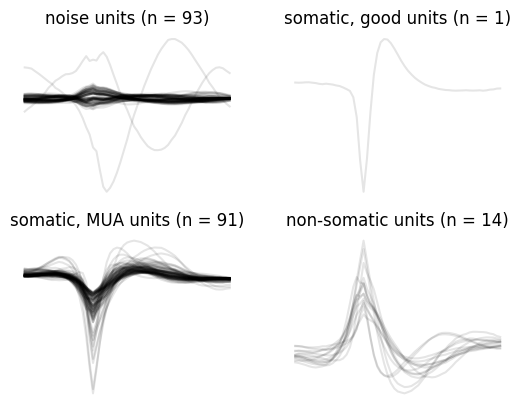

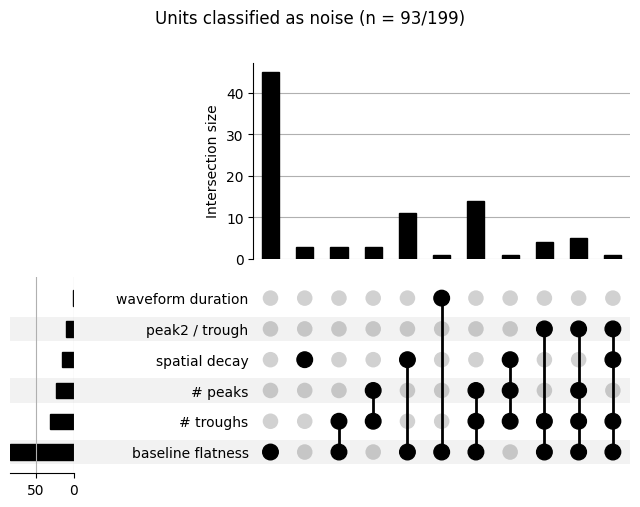

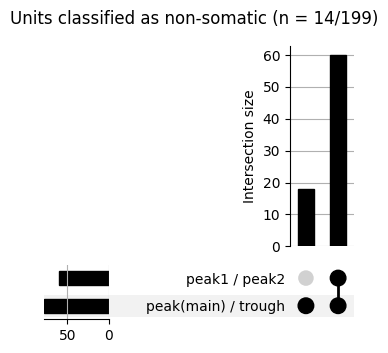

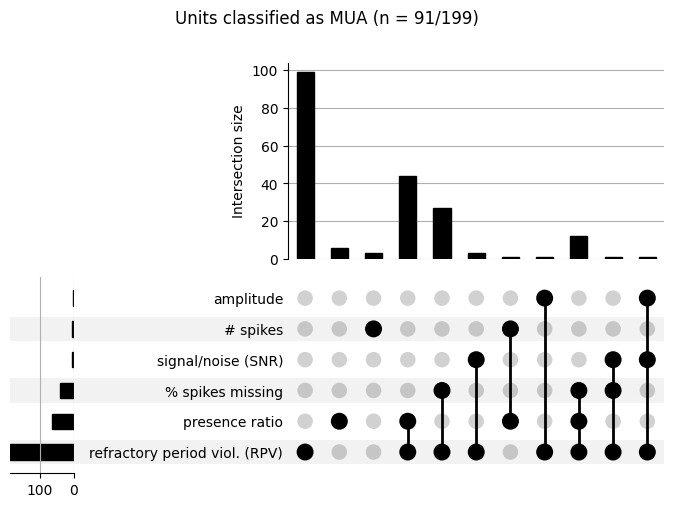

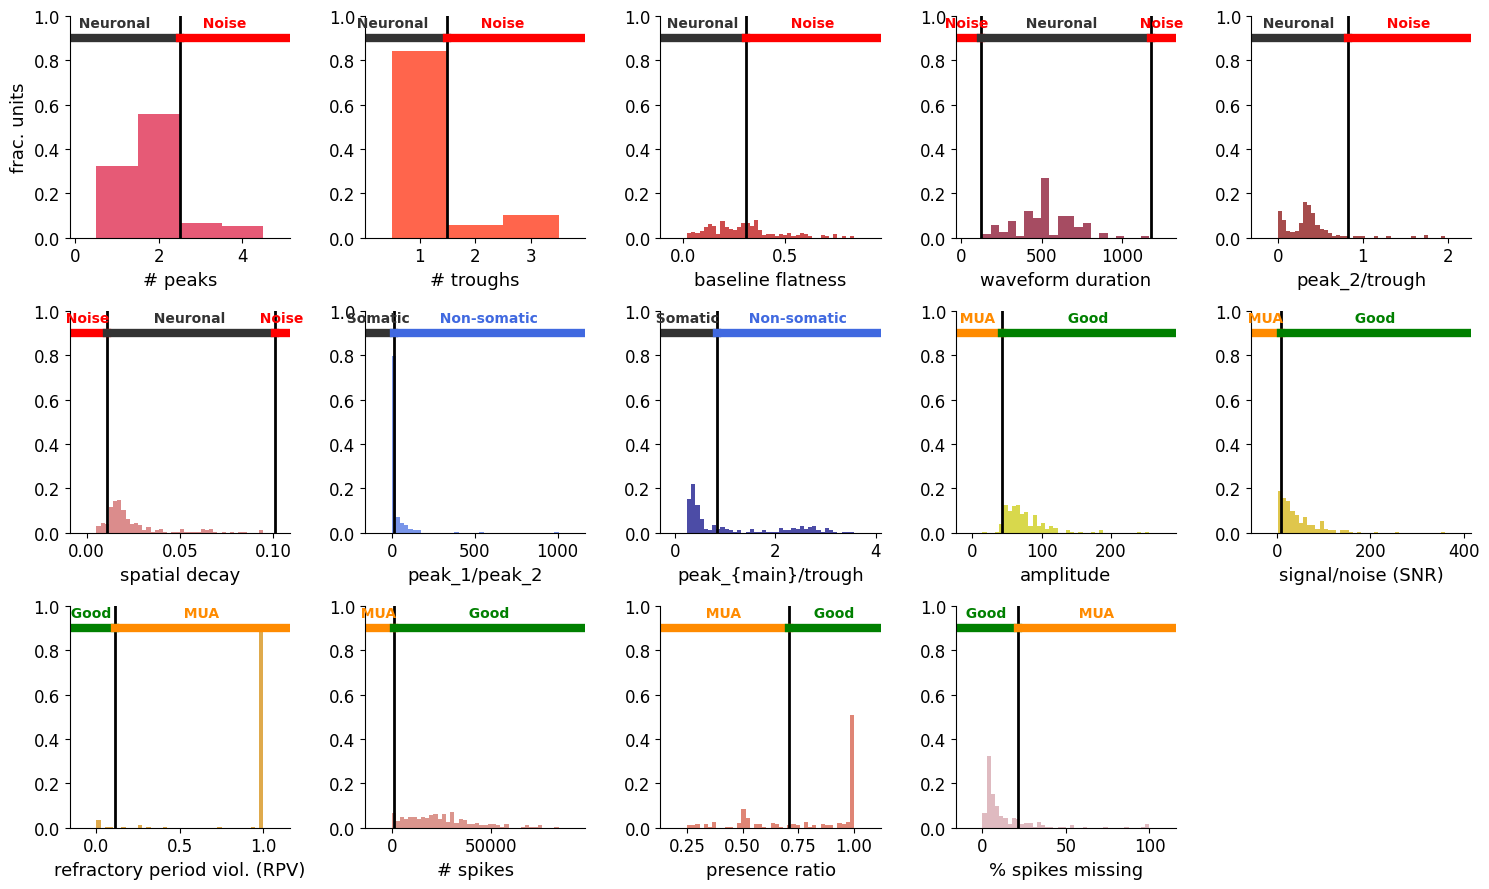


Saving results...
All expected metrics were successfully saved.


In [31]:

ks_dir = base_path / "sorted" / "sorter_output"
last_part = base_path.name  

imec_dir = base_path / (last_part + "_g0_imec0")
raw_file_path = imec_dir / (last_part + "_g0_t0.imec0.ap.bin")
meta_file_path = imec_dir / (last_part + "_g0_t0.imec0.ap.meta")


# Bombcell output
save_path = ks_dir / "bombcell"



param = bc.get_default_parameters(ks_dir, 
                                  raw_file=raw_file_path,
                                  meta_file=meta_file_path,
                                  kilosort_version=4)
(
    quality_metrics,
    param,
    unit_type,
    unit_type_string,
) = bc.run_bombcell(
    ks_dir, save_path, param
)

# Match Bombcell to SI and Phy

In [4]:

# Read input files
map_df = pd.read_csv(base_path / "sorted" / "phy" / "cluster_si_unit_ids.tsv", sep="\t")
bc_df = pd.read_csv(base_path / "sorted" / "sorter_output" / "bombcell" / "cluster_bc_unitType.tsv", sep="\t")
info_df = pd.read_csv(base_path / "sorted" / "phy" / "cluster_info.tsv", sep="\t")

# Merge by matching Kilosort IDs
merged = map_df.merge(bc_df, left_on="si_unit_id", right_on="cluster_id", how="left")

# Extract labels
phy_labels = merged[["cluster_id_x", "bc_unitType"]].rename(columns={"cluster_id_x": "cluster_id"})

# Merge labels into cluster info
info_df = info_df.merge(phy_labels, on="cluster_id", how="left")

# Optional label overwrite
info_df["group"] = info_df["bc_unitType"]

# Save output files
phy_labels.to_csv(base_path / "sorted" / "phy" / "cluster_bc_unitType.tsv", sep="\t", index=False)
info_df.to_csv(base_path / "sorted" / "phy" / "cluster_info.tsv", sep="\t", index=False)

# find ITI

In [ ]:

# --- Setup ---
channel_idx = 1  # Adjust as needed
channel_id = event.get_channel_ids()[channel_idx]
sf = event.get_sampling_frequency()

# --- Load entire trace ---
trace = event.get_traces(channel_ids=[channel_id])
signal = trace[:, 0]
time_vector = np.arange(len(signal)) / sf

# --- TTL edge detection ---
def extract_ttl_edges(signal, time_vector, threshold=2000):
    above_threshold = signal > threshold
    changes = np.diff(above_threshold.astype(int))
    
    rising_indices = np.where(changes == 1)[0] + 1
    falling_indices = np.where(changes == -1)[0] + 1

    edge_indices = np.concatenate((rising_indices, falling_indices))
    edge_types = np.array(['rising'] * len(rising_indices) + ['falling'] * len(falling_indices))

    sort_order = np.argsort(edge_indices)
    edge_indices = edge_indices[sort_order]
    edge_types = edge_types[sort_order]

    edge_times = time_vector[edge_indices]

    return edge_times, edge_types, edge_indices

edge_times, edge_types, edge_indices = extract_ttl_edges(signal, time_vector, threshold=100)

# --- Plot with markers ---
plt.figure(figsize=(12, 4))
plt.plot(time_vector, signal, label='Analog signal')
plt.plot(edge_times, signal[edge_indices], 'ro', label='TTL edges')
plt.title(f"TTL signal with edges - channel {channel_id}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.ylim(0, max(signal) * 1.1)
plt.show()

# --- Save to CSV ---
df_edges = pd.DataFrame({
    'time_seconds': edge_times,
    'edge_type': edge_types
})
#df_edges.to_csv(metapath / "ttl_edge_times.csv", index=False)
print("TTL edge times saved to 'ttl_edge_times.csv'")



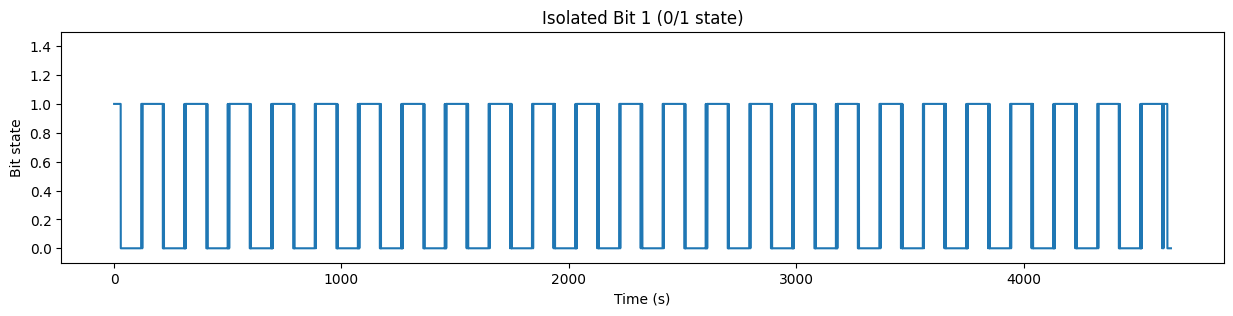

Extracted TTL events for bit 1 saved to D:\Data\raw\7644_naive\Meta/State_changes.csv


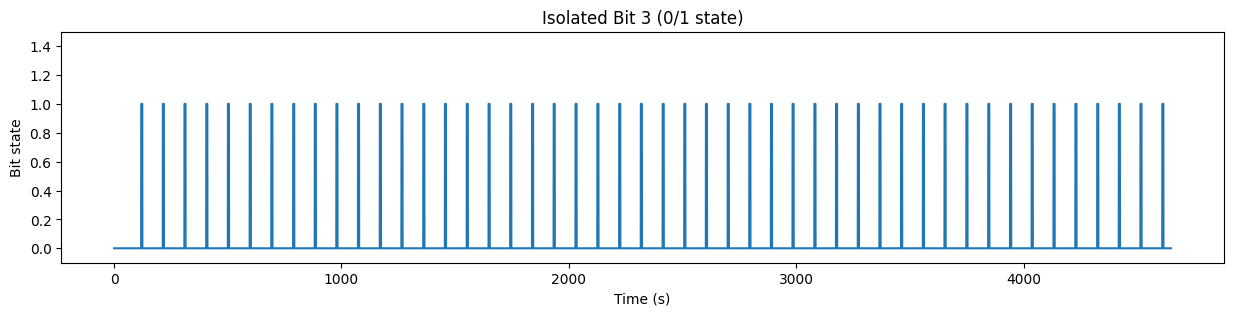

Extracted TTL events for bit 3 saved to D:\Data\raw\7644_naive\Meta/Audio.csv


In [10]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def extract_and_save_ttl_events(data, bit_name_pairs, save_path):
    """
    Extract TTL rising/falling events for multiple bits and save to CSV.
    """
    digital_signals = data.get_traces()
    digital_word = digital_signals[:, 8]
    sampling_rate = data.get_sampling_frequency()

    for bit, savename in bit_name_pairs:
        ttl_df = extract_ttl_from_bit(digital_word, bit, sampling_rate)
        filename = f"{savename}.csv"
        full_path = f"{save_path}/{filename}"

        ttl_df.to_csv(full_path, index=False)
        print(f"Extracted TTL events for bit {bit} saved to {full_path}")


def extract_ttl_from_bit(digital_word, bit, sampling_rate, plot=True):
    """
    Extract rising and falling TTL edges for a given bit.
    Returns a DataFrame with timestamps and edge_type columns.
    """
    ttl_signal = (digital_word >> bit) & 1
    time_axis = np.arange(len(ttl_signal)) / sampling_rate

    # optional plot
    if plot:
        plt.figure(figsize=(15, 3))
        plt.plot(time_axis, ttl_signal)
        plt.title(f'Isolated Bit {bit} (0/1 state)')
        plt.xlabel('Time (s)')
        plt.ylabel('Bit state')
        plt.ylim(-0.1, 1.5)
        plt.show()

    # detect edges
    diff = np.diff(ttl_signal)
    rising_indices = np.where(diff > 0)[0]
    falling_indices = np.where(diff < 0)[0]

    rising_timestamps = rising_indices / sampling_rate
    falling_timestamps = falling_indices / sampling_rate

    # combine into dataframe
    edges = np.concatenate([rising_timestamps, falling_timestamps])
    types = (['rising'] * len(rising_timestamps)) + (['falling'] * len(falling_timestamps))

    df = pd.DataFrame({'timestamps': edges, 'edge_type': types}).sort_values('timestamps').reset_index(drop=True)

    return df



pairs = [(1, 'State_changes'), (3, 'Audio')]
extract_and_save_ttl_events(event, pairs, metapath)





In [ ]:
def extract_ttl_from_bit(digital_word, bit, sampling_rate, min_gap_s=5.0):
    """
    Extract and plot TTL bursts, return first rising edge per train.
    """
    ttl_signal = (digital_word >> bit) & 1  # isolate bit
    time_axis = np.arange(len(ttl_signal)) / sampling_rate

    # Plot full or cropped TTL signal
    plt.figure(figsize=(15, 3))
    plt.plot(time_axis, ttl_signal)
    plt.title(f'Isolated Bit {bit} State (0 or 1)')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Bit State')
    plt.ylim(-0.1, 1.5)
    plt.xlim(100, 250) # plot first 10 seconds by default
    plt.show()

    # Rising edges (0 → 1)
    rising_indices = np.where(np.diff(ttl_signal) > 0)[0]
    rising_timestamps = rising_indices / sampling_rate

    # Detect first rising edge of each train
    if len(rising_timestamps) == 0:
        return np.array([])

    first_in_trains = [rising_timestamps[0]]
    for i in range(1, len(rising_timestamps)):
        if rising_timestamps[i] - rising_timestamps[i - 1] > min_gap_s:
            first_in_trains.append(rising_timestamps[i])

    return np.array(first_in_trains)

digital_signals = event.get_traces()
digital_word = digital_signals[:, 8]
sampling_rate = event.get_sampling_frequency()
ttl_timestamps = extract_ttl_from_bit(digital_word, 3, sampling_rate)
        
   

# phy

In [5]:
param_path = f"{basefolder}\\sorted\\phy\\params.py"
!phy template-gui "{param_path}"

10:43:38.873 [W] model:667            Skipping spike waveforms that do not exist, they will be extracted on the fly from the raw data as needed.
10:44:31.102 [I] supervisor:711       Change metadata_group for clusters 1 to good.
10:44:33.209 [I] supervisor:711       Change metadata_group for clusters 11 to good.
10:44:46.303 [I] supervisor:711       Change metadata_group for clusters 17 to good.
10:44:49.556 [I] supervisor:711       Change metadata_group for clusters 19 to good.
10:44:51.666 [I] supervisor:711       Change metadata_group for clusters 24 to good.
10:44:53.272 [I] supervisor:711       Change metadata_group for clusters 25 to good.
10:44:54.916 [I] supervisor:711       Change metadata_group for clusters 29 to good.
10:44:56.699 [I] supervisor:711       Change metadata_group for clusters 32 to good.
10:44:58.578 [I] supervisor:711       Change metadata_group for clusters 46 to good.
10:45:03.064 [I] supervisor:711       Change metadata_group for clusters 47 to good.
10:45:

# transfer to meta

In [6]:
src = base_path / "sorted" / "phy" / "cluster_info.tsv"
dst = metapath / "cluster_info.tsv"
shutil.copy2(src, dst)


WindowsPath('D:/Data/raw/7644_recall/Meta/cluster_info.tsv')

# optional

In [ ]:

# --- Setup ---
channel_idx = 4  # Adjust as needed
channel_id = event.get_channel_ids()[channel_idx]
sf = event.get_sampling_frequency()

# --- Load entire trace ---
trace = event.get_traces(channel_ids=[channel_id])
signal = trace[:, 0]
time_vector = np.arange(len(signal)) / sf

# --- TTL edge detection ---
def extract_ttl_edges(signal, time_vector, threshold=2000):
    above_threshold = signal > threshold
    changes = np.diff(above_threshold.astype(int))
    
    rising_indices = np.where(changes == 1)[0] + 1
    falling_indices = np.where(changes == -1)[0] + 1

    edge_indices = np.concatenate((rising_indices, falling_indices))
    edge_types = np.array(['rising'] * len(rising_indices) + ['falling'] * len(falling_indices))

    sort_order = np.argsort(edge_indices)
    edge_indices = edge_indices[sort_order]
    edge_types = edge_types[sort_order]

    edge_times = time_vector[edge_indices]

    return edge_times, edge_types, edge_indices

edge_times, edge_types, edge_indices = extract_ttl_edges(signal, time_vector, threshold=10000)

print(len(edge_times))



In [ ]:
# --- Plot with markers ---
plt.figure(figsize=(12, 4))
plt.plot(time_vector, signal, label='Analog signal')
plt.plot(edge_times, signal[edge_indices], 'ro', label='TTL edges')
plt.title(f"TTL signal with edges - channel {channel_id}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.ylim(0, max(signal) * 1.1)
plt.xlim(100,101)
plt.show()

# --- Save to CSV ---
df_edges = pd.DataFrame({
    'time_seconds': edge_times,
    'edge_type': edge_types
})

event


In [ ]:
import numpy as np
from scipy.signal import medfilt

def extract_ttl_edges_auto(signal, fs, hysteresis=0.1):
    """
    Detect TTL edges from an analog TTL-like signal without a fixed threshold.
    
    Parameters
    ----------
    signal : 1D np.array
        Analog TTL signal.
    fs : float
        Sampling frequency in Hz.
    hysteresis : float
        Fraction of amplitude range for hysteresis thresholding.
    
    Returns
    -------
    edge_times : np.array
        Times of detected edges in seconds.
    edge_types : np.array
        Array of 'rising' or 'falling' corresponding to each edge.
    edge_indices : np.array
        Sample indices of detected edges.
    """
    # --- 1. Denoise a bit ---
    signal_f = medfilt(signal, kernel_size=5)

    # --- 2. Estimate logic levels automatically ---
    hist, bins = np.histogram(signal_f, bins=200)
    peaks = bins[np.argsort(hist)[-2:]]  # two most common levels
    v_low, v_high = np.sort(peaks)
    
    # --- 3. Compute thresholds with hysteresis ---
    v_mid_low  = v_low  + hysteresis * (v_high - v_low)
    v_mid_high = v_high - hysteresis * (v_high - v_low)

    # --- 4. Convert to digital with hysteresis ---
    digital = np.zeros_like(signal_f, dtype=int)
    state = 0
    for i, v in enumerate(signal_f):
        if state == 0 and v > v_mid_high:
            state = 1
        elif state == 1 and v < v_mid_low:
            state = 0
        digital[i] = state

    # --- 5. Detect edges ---
    changes = np.diff(digital)
    rising_indices  = np.where(changes == 1)[0] + 1
    falling_indices = np.where(changes == -1)[0] + 1

    edge_indices = np.concatenate((rising_indices, falling_indices))
    edge_types = np.array(['rising'] * len(rising_indices) + ['falling'] * len(falling_indices))

    sort_order = np.argsort(edge_indices)
    edge_indices = edge_indices[sort_order]
    edge_types = edge_types[sort_order]
    
    edge_times = edge_indices / fs

    return edge_times, edge_types, edge_indices

channel_idx = 1  # Adjust as needed
channel_id = event.get_channel_ids()[channel_idx]

sigA = event.get_traces(channel_ids=[channel_id]).squeeze()
sf = event.get_sampling_frequency()


edge_times, edge_types, edge_indices = extract_ttl_edges_auto(sigA, sf)
print(edge_times[:10], edge_types[:10])


In [ ]:
import numpy as np
from scipy.signal import medfilt

def extract_ttl_edges_auto(signal, fs, hysteresis=0.1):
    """Detect TTL edges robustly from analog signal."""
    signal_f = medfilt(signal, kernel_size=5)
    hist, bins = np.histogram(signal_f, bins=200)
    peaks = bins[np.argsort(hist)[-2:]]  # two most common levels
    v_low, v_high = np.sort(peaks)
    v_mid_low = v_low + hysteresis * (v_high - v_low)
    v_mid_high = v_high - hysteresis * (v_high - v_low)

    digital = np.zeros_like(signal_f, dtype=int)
    state = 0
    for i, v in enumerate(signal_f):
        if state == 0 and v > v_mid_high:
            state = 1
        elif state == 1 and v < v_mid_low:
            state = 0
        digital[i] = state

    changes = np.diff(digital)
    rising_indices = np.where(changes == 1)[0] + 1
    falling_indices = np.where(changes == -1)[0] + 1

    edge_indices = np.concatenate((rising_indices, falling_indices))
    edge_types = np.array(['rising'] * len(rising_indices) + ['falling'] * len(falling_indices))
    sort_order = np.argsort(edge_indices)
    edge_indices = edge_indices[sort_order]
    edge_types = edge_types[sort_order]
    edge_times = edge_indices / fs
    return edge_times, edge_types, edge_indices, digital

def quadrature_speed_direction(sigA, sigB, fs, pulses_per_rev=360, hysteresis=0.1):
    """
    Compute rotational speed (deg/s) and direction from analog quadrature encoder.
    """
    # --- Extract TTL edges ---
    _, _, _, digA = extract_ttl_edges_auto(sigA, fs, hysteresis)
    _, _, _, digB = extract_ttl_edges_auto(sigB, fs, hysteresis)

    # Detect rising edges on channel A
    rising_A = np.where((digA[1:] > digA[:-1]) & (digA[:-1] == 0))[0] + 1
    t_edges = rising_A / fs

    # Determine direction at each rising edge using channel B
    direction = np.where(digB[rising_A] == 0, 1, -1)  # 1=CW, -1=CCW

    # Incremental rotation per pulse
    deg_per_edge = 360.0 / pulses_per_rev
    dtheta = direction * deg_per_edge

    # Instantaneous speed
    dt = np.diff(t_edges)
    speed = np.diff(np.cumsum(dtheta)) / dt
    mid_time = (t_edges[1:] + t_edges[:-1]) / 2

    return mid_time, speed, direction[1:]

# --- Example usage with SpikeInterface / NIDAQ ---
fs = event.get_sampling_frequency()
sigA = event.get_traces(channel_ids=[event.get_channel_ids()[1]]).squeeze()
sigB = event.get_traces(channel_ids=[event.get_channel_ids()[2]]).squeeze()

ts, speed, dirn = quadrature_speed_direction(sigA, sigB, fs, pulses_per_rev=360)
print(f"Mean speed: {np.mean(np.abs(speed)):.1f} deg/s, direction: {'CW' if np.mean(dirn)>0 else 'CCW'}")
len(sigA)


from scipy.interpolate import interp1d

fs = event.get_sampling_frequency()
sig_len = len(sigA)
time_full = np.arange(sig_len) / fs

# interpolate speed and direction to full sample times
f_speed = interp1d(ts, speed, kind='previous', fill_value="extrapolate")
speed_full = f_speed(time_full)

f_dir = interp1d(ts, dirn, kind='previous', fill_value="extrapolate")
dir_full = f_dir(time_full)

In [ ]:
import numpy as np
from scipy.signal import medfilt
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

def extract_ttl_edges_auto(signal, fs, hysteresis=0.1):
    """Detect TTL edges robustly from analog signal."""
    signal_f = medfilt(signal, kernel_size=5)
    hist, bins = np.histogram(signal_f, bins=200)
    peaks = bins[np.argsort(hist)[-2:]]  # two most common levels
    v_low, v_high = np.sort(peaks)
    v_mid_low = v_low + hysteresis * (v_high - v_low)
    v_mid_high = v_high - hysteresis * (v_high - v_low)

    digital = np.zeros_like(signal_f, dtype=int)
    state = 0
    for i, v in enumerate(signal_f):
        if state == 0 and v > v_mid_high:
            state = 1
        elif state == 1 and v < v_mid_low:
            state = 0
        digital[i] = state

    return digital

def quadrature_speed_direction(sigA, sigB, fs, pulses_per_rev=360, hysteresis=0.1):
    """Compute speed (deg/s) and direction (1=CW, -1=CCW, 0=no movement)."""
    sig_len = len(sigA)
    time_full = np.arange(sig_len) / fs  # seconds

    # convert to digital
    digA = extract_ttl_edges_auto(sigA, fs, hysteresis)
    digB = extract_ttl_edges_auto(sigB, fs, hysteresis)

    # detect rising edges on channel A
    rising_A = np.where((digA[1:] > digA[:-1]) & (digA[:-1] == 0))[0] + 1
    t_edges = rising_A / fs

    # compute incremental rotation
    direction_edges = np.where(digB[rising_A] == 0, 1, -1)
    deg_per_edge = 360.0 / pulses_per_rev
    dtheta = direction_edges * deg_per_edge

    # instantaneous speed between pulses
    dt = np.diff(t_edges)
    speed_edges = np.diff(np.cumsum(dtheta)) / dt
    dir_edges = direction_edges[1:]

    # interpolate speed and direction to full sample times
    if len(t_edges) > 1:
        f_speed = interp1d((t_edges[1:] + t_edges[:-1])/2, speed_edges,
                           kind='previous', bounds_error=False, fill_value=0)
        f_dir = interp1d((t_edges[1:] + t_edges[:-1])/2, dir_edges,
                         kind='previous', bounds_error=False, fill_value=0)
        speed_full = f_speed(time_full)
        dir_full = f_dir(time_full)
    else:
        speed_full = np.zeros(sig_len)
        dir_full = np.zeros(sig_len)

    return time_full*1000, speed_full, dir_full  # time in ms




fs = event.get_sampling_frequency()
sigA = event.get_traces(channel_ids=[event.get_channel_ids()[6]]).squeeze()
sigB = event.get_traces(channel_ids=[event.get_channel_ids()[5]]).squeeze()
ts_ms, speed, direction = quadrature_speed_direction(sigA, sigB, fs, pulses_per_rev=225)

downsample_factor = 1  # plot every Xth sample
ts_plot = ts_ms[::downsample_factor]/1000
speed_plot = speed[::downsample_factor]
dir_plot = direction[::downsample_factor]

plt.figure(figsize=(10,4))
colors = np.where(dir_plot==1, 'blue', np.where(dir_plot==-1, 'red', 'gray'))
plt.plot(ts_plot, speed_plot, color='black', linewidth=0.5)  # line for speed
for d_color in [1, -1, 0]:
    mask = dir_plot == d_color
    plt.plot(ts_plot[mask], speed_plot[mask], '.', color={1:'blue', -1:'red', 0:'gray'}[d_color], markersize=2)

plt.xlabel("Time (ms)")
plt.ylabel("Speed (deg/s)")
plt.title("Rotational Speed vs Time")
#plt.ylim(37,50)
#plt.xlim(2300,2400)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# assume ts_plot, speed_plot, dir_plot are numpy arrays
df = pd.DataFrame({'t': ts_plot, 'speed': speed_plot, 'dir': dir_plot})

# rolling smoothing (change window size for more/less smoothing)
df['smooth'] = df['speed'].rolling(window=1000, center=True, min_periods=1).mean()

plt.figure(figsize=(10,4))
colors = np.where(df['dir']==1, 'blue', np.where(df['dir']==-1, 'red', 'gray'))

# smoothed line
plt.plot(df['t'], df['smooth'], color='black', linewidth=1.5, alpha=0.8)

# individual points by direction
#plt.scatter(df['t'], df['speed'], c=colors, s=4, alpha=0.4)

plt.xlabel("Time (ms)")
plt.ylabel("Speed (deg/s)")
plt.title("Rotational Speed vs Time (Smoothed)")
plt.show()
